In [1]:
question_json = 'data/CLEVR_v1.0/questions/CLEVR_val_questions.json' 
# question_json = 'data/CLEVR-Humans/CLEVR-Humans-val.json' 
# question_pt = 'input_human/val_questions.pt'
feature_h5 = 'input_all/val_features.h5' # path to trainval_feature.h5
question_pt = 'input_ban/val_questions.pt'
# ckpt = 'entity_human_pretrain/model.pt'
ckpt = 'timeban_4/model.pt'
# ckpt = 'dafa/model.pt'
# ckpt = 'ban_all/model.pt'
# ckpt = 'dfaftime_2/model.pt'
# ckpt = 'butd/model.pt'
# ckpt = 'butd_human/model.pt'
# ckpt = 'entity_human/model.pt'
# ckpt = 'dfaftime_2_human/model.pt'
image_dir = 'data/CLEVR_v1.0/images/val' # path to mscoco/val2014, containing all mscoco val images
ann_file = 'data/objects/clevr_val_objs_pretrained.json' # path to mscoco/annotations/instances_val2014.json
vocab_json = 'input_human/vocab.json'

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os,sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(sys.argv[1])))) # to import shared utils
import torch
import numpy as np
import pickle
import json
import h5py
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import _pickle as cPickle
import re
from torch.utils.data import Dataset, DataLoader, dataloader

In [3]:
def todevice(tensor, device):
    if isinstance(tensor, list) or isinstance(tensor, tuple):
        assert isinstance(tensor[0], torch.Tensor)
        return [todevice(t, device) for t in tensor]
    elif isinstance(tensor, torch.Tensor):
        return tensor.to(device)

def invert_dict(d):
    return {v: k for k, v in d.items()}

def expand_batch(*args):
    return (t.unsqueeze(0) for t in args)

def load_vocab(path):
    with open(path, 'r') as f:
        vocab = json.load(f)
        vocab['question_idx_to_token'] = invert_dict(vocab['question_token_to_idx'])
        vocab['answer_idx_to_token'] = invert_dict(vocab['answer_token_to_idx'])
        # vocab['program_idx_to_token'] = invert_dict(vocab['program_token_to_idx'])
    return vocab

def expand_batch(*args):
    return (t.unsqueeze(0) for t in args)

class CLEVRDataset(Dataset):

    def __init__(self, **kwargs):
        
        vocab_json_path = str(kwargs.pop('vocab_json'))
        print('loading vocab from %s' % (vocab_json_path))
        vocab = load_vocab(vocab_json_path)

        question_pt_path = str(kwargs.pop('question_pt'))
        print('loading questions from %s' % (question_pt_path))
        
        with open(question_pt_path, 'rb') as f:
            obj = pickle.load(f)
            questions = obj['questions']
            questions_len = obj['questions_len']
            image_indices = obj['image_idxs']
            answers = obj['answers']
            questions_mask = obj['questions_mask']
            entity_starts = obj['e_starts']
            entity_ends = obj['e_ends']
            entity_masks = obj['e_masks']
            orig_indices = obj['orig_idxs']
        
        self.feature_h5 = kwargs.pop('feature_h5')
        
        self.vocab = vocab
        
        # convert data to tensor
        self.all_answers = answers
        self.all_questions = torch.LongTensor(np.asarray(questions))
        self.all_questions_len = torch.LongTensor(np.asarray(questions_len))
        self.all_image_idxs = torch.LongTensor(np.asarray(image_indices))
        self.all_orig_idxs = torch.LongTensor(np.asarray(orig_indices))
        self.all_questions_mask = torch.FloatTensor(np.asarray(questions_mask))
        self.all_entity_starts = torch.LongTensor(np.asarray(entity_starts))
        self.all_entity_ends = torch.LongTensor(np.asarray(entity_ends))
        self.all_entity_masks = torch.LongTensor(np.asarray(entity_masks))


        self.num_answer = len(vocab['answer_token_to_idx'])
        self.num_token = len(vocab['question_token_to_idx'])


    def __getitem__(self, index):
        answer = self.all_answers[index] if self.all_answers is not None else None
        question = self.all_questions[index]
        question_len = self.all_questions_len[index]
        question_mask = self.all_questions_mask[index]

        entity_start = self.all_entity_starts[index]
        entity_end = self.all_entity_ends[index]
        entity_mask = self.all_entity_masks[index]

        image_idx = self.all_image_idxs[index].item() #image_id
        orig_idx = self.all_orig_idxs[index].item()

        with h5py.File(self.feature_h5, 'r') as f:
            vision_feat = f['features'][image_idx]

        # if self.use_spatial:
        #     vision_feat = np.concatenate((vision_feat, spatial_feat), axis=0)
        
        #########
        num_obj, vec_size = vision_feat.shape
        edge_vec = np.zeros((num_obj, num_obj, vec_size))
        relation_mask = np.zeros((num_obj,num_obj))
        for i in range(num_obj):
            for j in range(num_obj):
                if sum(vision_feat[i]) != 0 and sum(vision_feat[j]) != 0:
                    relation_mask[i, j] = 1
                    edge_vec[i,j] = vision_feat[i] - vision_feat[j]
        edge_vec = torch.from_numpy(edge_vec).float()
        relation_mask = torch.from_numpy(relation_mask).byte()
        vision_feat = torch.from_numpy(vision_feat).float()
        
        q_onehot = torch.zeros(question_len, self.num_token).scatter_(1, question[:question_len].unsqueeze(-1), 1)
        entity_label = []
        for i in range(5):
            ee = q_onehot[entity_start[i] : entity_end[i]].sum(0)
            entity_label.append(ee)
        
        entity_label = torch.stack(entity_label)

        return (orig_idx, image_idx, answer, question, vision_feat, entity_start, entity_end, entity_mask, entity_label,
         edge_vec, relation_mask, question_mask, question_len)
    
    def __len__(self):
        return len(self.all_questions)

In [4]:
import pycocotools.mask as mask_util
with open(question_json, 'r') as f:
    questions_json = json.load(f)

with open(vocab_json) as f:
    vocab = json.load(f)
    
with open(ann_file) as f:
    anns = json.load(f)
    
token_to_index = vocab['question_token_to_idx']
answer_to_index = vocab['answer_token_to_idx']

scenes = [{
        'image_index': i,
        'image_filename': 'CLEVR_val_%06d.png' %(i),
        'objects': []
    } for i in range(15000)]

obj_masks = anns['object_masks']
img_ids = anns['image_idxs']
cat_ids = anns['category_idxs']

for i in range (len(obj_masks)):
    mask = obj_masks[i]
    img_id = img_ids[i]
    scenes[img_id]['objects'].append(mask_util.decode(mask))

questions = questions_json['questions']


In [5]:
device = 'cuda'
loaded = torch.load(ckpt, map_location={'cuda:0': 'cpu'})
model_kwargs = loaded['model_kwargs']
    
dataset_kwargs = {
            'question_pt': question_pt,
            'vocab_json': vocab_json,
            'feature_h5': feature_h5,
        }

validate_dataset = CLEVRDataset(**dataset_kwargs)

loading vocab from input_human/vocab.json
loading questions from input_ban/val_questions.pt


In [6]:
def drawrect(drawcontext, xy, outline=None, width=0):
    x1, y1, x2, y2 = xy
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)
    
def plot_mask(image, masks):
    mask_all = np.zeros_like(image[:,:,0])
    for m in masks:
        mask_all = mask_all + m
#         drawrect(draw, box, outline='green', width=3)
    for i in range(3):
        image[:,:,i] = image[:,:,i] * mask_all
    return image, mask_all

def plot_attention(img, masks, att, mask_back):
    mask_all = np.zeros_like(img[:,:,0])
    for i in range(len(masks)):
        mask_all = mask_all + att[i].item() * masks[i]
    
    mask_gray = mask_all > 0.2

    for i in range(4):
        img[:,:,i] = img[:,:,i] * mask_all * mask_gray + 100*(1-mask_gray)
    return img

In [7]:
#choose a test item
index = 300
batch = validate_dataset.__getitem__(index)

orig_idx, image_idx, answer, *batch_input = [todevice(x, device) for x in batch]
batch_input = [x.unsqueeze(0).detach() for x in batch_input]
question_id = batch[0]
image_id = batch[1]
image_filename = 'CLEVR_val_%06d.png' %image_id

In [8]:
v_mask = batch_input[1].sum(-1).masked_fill(batch_input[1].sum(-1) > 0, 1)
v_mask

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

In [9]:
# questions[index]['program']

The small object that is the same color as the big matte cube is what shape?


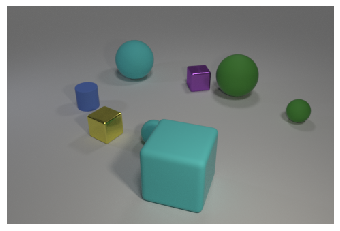

In [10]:
q_str = questions[index]['question']
print(q_str)
img = io.imread(os.path.join(image_dir, image_filename))

plot_img, mask_back = plot_mask(copy.copy(img), scenes[image_id]['objects'])
plt.axis('off')
plt.imshow(img[:,:,:3])

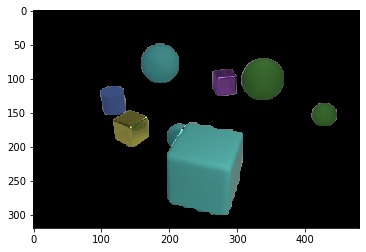

In [11]:
plt.imshow(plot_img)

In [12]:
from timeban_forward import Net
model_kwargs.update({'vocab': validate_dataset.vocab, 'device': device})
model = Net(**model_kwargs).to(device)

model.load_state_dict(loaded['state_dict'])

<All keys matched successfully>

In [13]:
model.eval()
output, z_seq = model(*batch_input)

In [14]:
ans_idx = torch.argmax(output.squeeze(0))
print('output:')
print(list(answer_to_index)[ans_idx])

output:
sphere


In [15]:
print('label:')
print(list(answer_to_index)[batch[2]])

label:
sphere


tensor(0.3733, device='cuda:0', grad_fn=<MaxBackward1>)


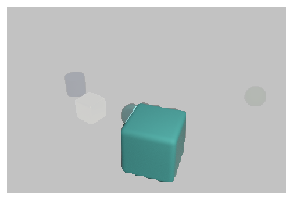

tensor(0.3768, device='cuda:0', grad_fn=<MaxBackward1>)


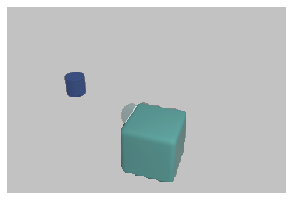

tensor(0.6520, device='cuda:0', grad_fn=<MaxBackward1>)


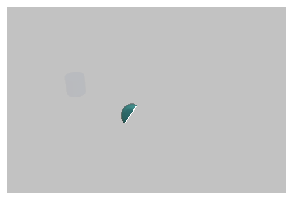

tensor(0.9035, device='cuda:0', grad_fn=<MaxBackward1>)


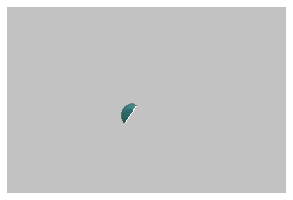

In [21]:
import torch.nn.functional as F
pylab.rcParams['figure.figsize'] = (5.0, 10.0)
for t in range(len(z_seq)):
    a = z_seq[t].sample().exp().squeeze(0) 
#     a = F.softmax(z_seq[t].logits.masked_fill_(v_mask == 0, -float('inf')).squeeze(0), dim=-1)
#     a = F.softmax(z_seq[t].logits.squeeze(0), dim=-1)
#     a = F.softmax(z_seq[t].sum(-1).squeeze(0), dim=-1)
#     a = z_seq[t].masked_fill_(z_seq[t]==-float('inf'), 0)
#     a = F.softmax(a.sum(-1).squeeze(0), dim=-1)
    print(a.max())
    a = a / (a.max())
    plot_img = plot_attention(copy.copy(img), scenes[image_id]['objects'], a, mask_back)
    plt.axis('off')
    plt.imshow(plot_img)
    plt.pause(0.0001)

In [17]:
z_seq = z_seq / (z_seq.max())
plot_img = plot_attention(copy.copy(img), scenes[image_id]['objects'], z_seq.squeeze(0), mask_back)
plt.axis('off')
plt.imshow(plot_img)

AttributeError: 'list' object has no attribute 'max'